# POC (e): compare two areas

## Copy request_api and mask function

In [6]:
import cdsapi
import time

# a wrapper function to request ERA5 API
# f_name: the name of the file to be requested
# shape: the ARBITRARY shape of the area to be requested
#        if None, the whole world will be queried
#        otherwise, the request ERA5 API with the bounding box of the shape
# return: the path of the file downloaded
def request_era5_api(f_name, shape=None, day = ['05'], month = ['01']):
    fpath = f'data/download/{f_name}'
    if shape is None:
        area = [90, -180, -90, 180]
    else:
        west, sorth, east, north = shape.bounds
        area = [north, west, sorth, east]

    print('\n### ~~~~~~ ###')
    print('START requesting ERA5 API')
    start = time.time()

    c = cdsapi.Client()
    c.retrieve('reanalysis-era5-single-levels', {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': '2m_temperature',
        'year': '2022',
        'month': month,
        'day': day,
        'time': [
            '00:00',
            '01:00',
            '02:00',
            '03:00',
            '04:00',
            '05:00',
            '06:00',
            '07:00',
            '08:00',
            '09:00',
            '10:00',
            '11:00',
            '12:00',
            '13:00',
            '14:00',
            '15:00',
            '16:00',
            '17:00',
            '18:00',
            '19:00',
            '20:00',
            '21:00',
            '22:00',
            '23:00',
        ],
        'area': area,
    }, fpath)

    end = time.time()
    print(f'DONE requesting ERA5 API in {end - start} seconds')
    print('### ~~~~~~ ###\n')

    return fpath

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import folium
import time

# a function to mask the raster data with arbitrary shape
# fpath: the path of the raster data
# shape: the ARBITRARY shape
# return: the mask of the raster data, which is a boolean 2-D array
def shape_mask(fpath, shape):
    print('\n### ~~~~~~ ###')
    print('START masking raster data with arbitrary shape')
    start = time.time()

    gdf_shape = gpd.GeoDataFrame(geometry=[shape], crs=4326)

    ds = xr.open_dataset(fpath)
    print(f'shape of the whole raster data: {ds["t2m"].shape}')
    ds_2d = ds.isel(time=0)  # using a 2-D slice of the raster to construct the geospatail content of the pixels
    print(f'shape of the sliced raster data: {ds_2d["t2m"].shape}')

    # take a record of the lat/lon location in the raster data
    df_lat = pd.DataFrame(enumerate(ds_2d['latitude'].values), columns=['lat_index', 'latitude'])
    df_lon = pd.DataFrame(enumerate(ds_2d['longitude'].values), columns=['lon_index', 'longitude'])

    df_2d = ds_2d.to_dataframe()
    df_2d = df_2d.reset_index()
    df_2d = df_2d[['latitude', 'longitude', 't2m']]
    df_2d = df_2d.merge(df_lat, on='latitude')
    df_2d = df_2d.merge(df_lon, on='longitude')
    gdf_2d = gpd.GeoDataFrame(
        df_2d,
        geometry=gpd.points_from_xy(df_2d.longitude, df_2d.latitude),
        crs=4326,
    )  # construct the geospatail dataframe of the pixels
    gdf_masked = gdf_2d.sjoin(gdf_shape, how='inner', predicate="within")  # join the pixels with the shape, use GeoPandas spatial join

    # construct the mask of based on the lat/lon location of the pixels within the shape
    lat_index = gdf_masked['lat_index'].values
    lon_index = gdf_masked['lon_index'].values
    mask = np.zeros(ds_2d['t2m'].shape)
    mask[lat_index, lon_index] = 1
    mask = mask.astype(bool)

    end = time.time()
    print(f'DONE masking raster data with arbitrary shape in {end - start} seconds')
    print('### ~~~~~~ ###')

    # visualize the shape, all pixels and masked pixels
    m = gdf_shape.explore(name='shape', tiles='Stamen Terrain')
    gdf_2d.explore(m=m, column='t2m', name='api_request_points', cmap='Oranges')
    gdf_masked.explore(m=m, column='t2m', name='masked_points', cmap='Blues')
    folium.LayerControl().add_to(m)
    # m.save('poc_a_map.html')
    return mask, m

# Working example

In [9]:
import geopandas as gpd

month = [str(i).zfill(2) for i in range(1, 6)]
day = [str(i).zfill(2) for i in range(1, 32)]

gdf_1 = gpd.read_file('data/vector/greenland_main_island.geojson')
shape_1 = gdf_1.loc[0, 'geometry']  # get an object of an arbitrary shape
fpath_1 = request_era5_api('poc_e1.nc', shape=shape_1, day=day, month=month)
mask_1, m_1 = shape_mask(fpath_1, shape_1)

gdf_2 = gpd.read_file('data/vector/tri.geojson')
shape_2 = gdf_2.loc[0, 'geometry']
fpath_2 = request_era5_api('poc_e2.nc', shape=shape_2, day=day, month=month)
mask_2, m_2 = shape_mask(fpath_2, shape_2)


### ~~~~~~ ###
START requesting ERA5 API


2023-07-11 16:04:41,972 INFO Welcome to the CDS
2023-07-11 16:04:41,974 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-07-11 16:04:42,183 INFO Request is completed
2023-07-11 16:04:42,184 INFO Downloading https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data6/adaptor.mars.internal-1689109321.5019417-26411-1-ece2d4e1-856c-4311-ba40-cb577d54dcfd.nc to data/download/poc_e1.nc (161.9M)
2023-07-11 16:04:56,386 INFO Download rate 11.4M/s 


DONE requesting ERA5 API in 15.121106147766113 seconds
### ~~~~~~ ###


### ~~~~~~ ###
START masking raster data with arbitrary shape
shape of the whole raster data: (3624, 96, 244)
shape of the sliced raster data: (96, 244)
DONE masking raster data with arbitrary shape in 0.16867709159851074 seconds
### ~~~~~~ ###


2023-07-11 16:04:59,001 INFO Welcome to the CDS
2023-07-11 16:04:59,002 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels



### ~~~~~~ ###
START requesting ERA5 API


2023-07-11 16:04:59,157 INFO Request is queued
2023-07-11 16:05:00,314 INFO Request is running
2023-07-11 16:06:54,056 INFO Request is completed
2023-07-11 16:06:54,059 INFO Downloading https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data5/adaptor.mars.internal-1689109587.6282635-10915-19-e213cbe6-fa45-4264-b537-ac49db930d45.nc to data/download/poc_e2.nc (23M)
2023-07-11 16:06:56,916 INFO Download rate 8M/s     


DONE requesting ERA5 API in 118.20902395248413 seconds
### ~~~~~~ ###


### ~~~~~~ ###
START masking raster data with arbitrary shape
shape of the whole raster data: (3624, 41, 81)
shape of the sliced raster data: (41, 81)
DONE masking raster data with arbitrary shape in 0.056688785552978516 seconds
### ~~~~~~ ###


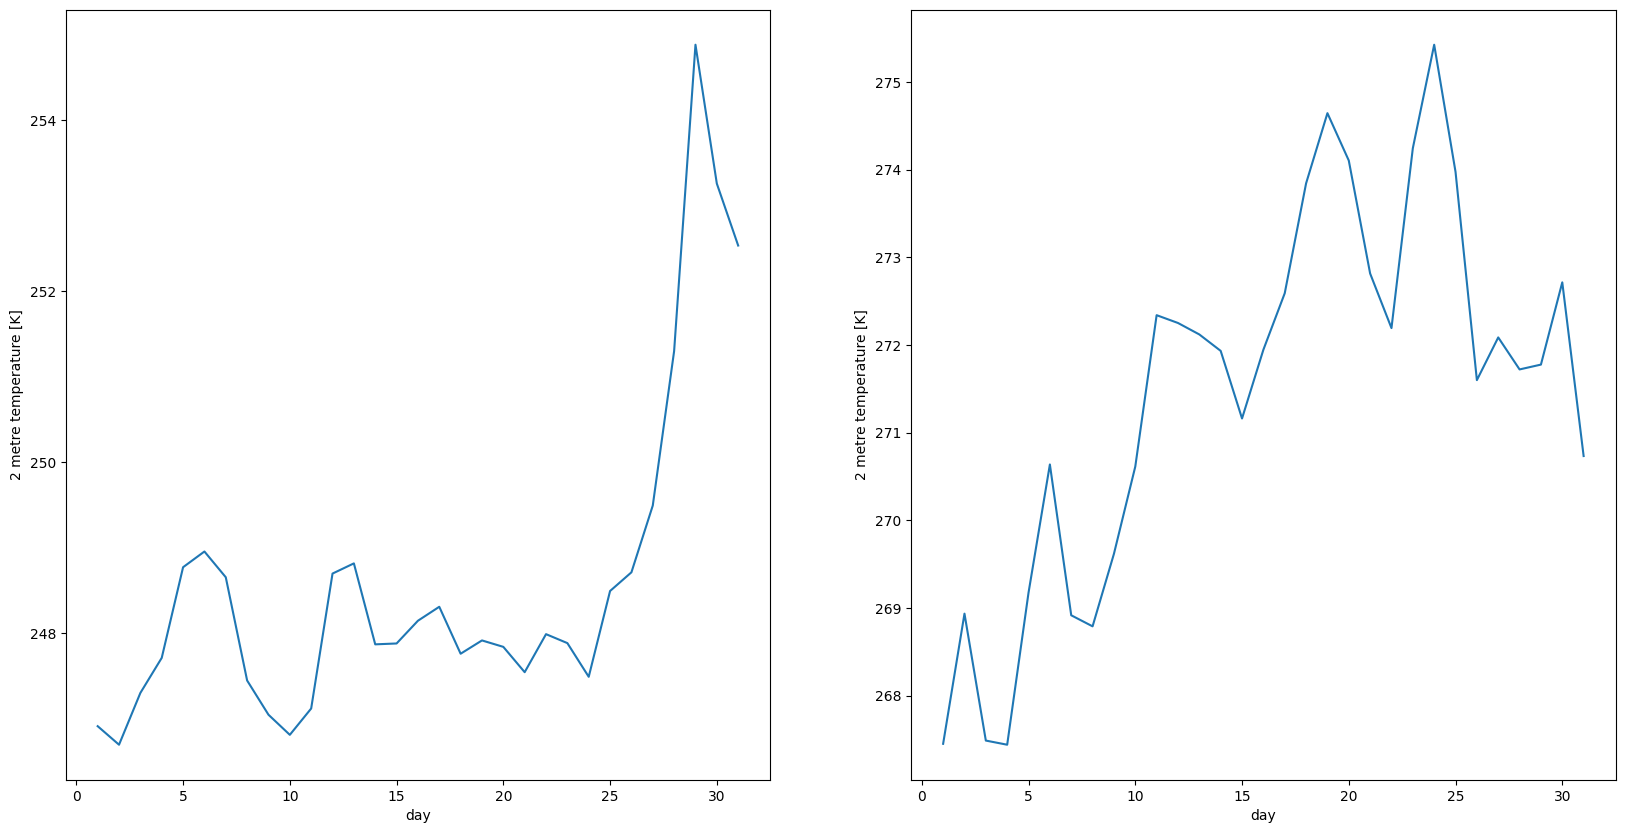

In [11]:
# Using pure xarray methods from poc(d)

import xarray as xr
import matplotlib.pyplot as plt

ds_1 = xr.open_dataset(fpath_1)
masked_1 = ds_1.where(mask_1)  # mask the raster data with shape mask
grouped_1 = masked_1.groupby('time.day')  # groupby day
agg_1 = grouped_1.mean(dim=['latitude', 'longitude', 'time'])  # aggregate each group by mean across latitude, longitude and time


ds_2 = xr.open_dataset(fpath_2)
masked_2 = ds_2.where(mask_2)
grouped_2 = masked_2.groupby('time.day')
agg_2 = grouped_2.mean(dim=['latitude', 'longitude', 'time'])


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
agg_1['t2m'].plot(ax=ax1)
agg_2['t2m'].plot(ax=ax2)